## Importing the Datasets

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankitakokes
Your Kaggle Key: ··········


100%|██████████| 34.1M/34.1M [00:00<00:00, 89.6MB/s]


In [3]:
import os
import tarfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as T

In [4]:
project_name='Alzheimer Detection based on Images of MRI Segmentation'

## Loading the data

In [5]:
data_dir = '/content/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'

In [6]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

train_transf = T.Compose([
                          T.transforms.RandomCrop((208, 176), padding=8, padding_mode='reflect'),
                          T.transforms.ToTensor()
                         ])

apply_transformation = True
train_ds = ImageFolder(data_dir+'/train', transform=train_transf) if apply_transformation else  ImageFolder(data_dir+'/train', transform=ToTensor())
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())

Exploring the data

In [8]:
from collections import Counter

d = Counter(train_ds.targets + test_ds.targets)
idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
d = {idx_to_class[k]:v for k,v in d.items()}
d

{'MildDemented': 896,
 'ModerateDemented': 64,
 'NonDemented': 3200,
 'VeryMildDemented': 2240}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


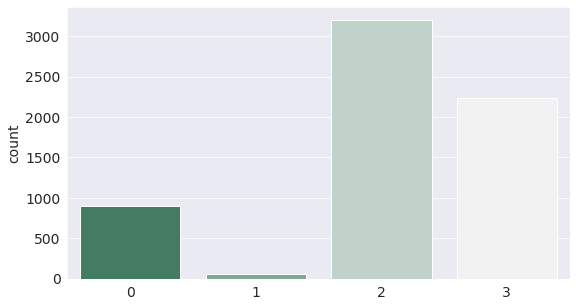

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
sns.countplot(train_ds.targets + test_ds.targets, palette=sns.diverging_palette(150, 275, sep=80, n=9), )

Label:  VeryMildDemented (3)


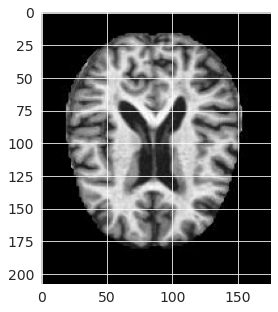

In [10]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*train_ds[4000])

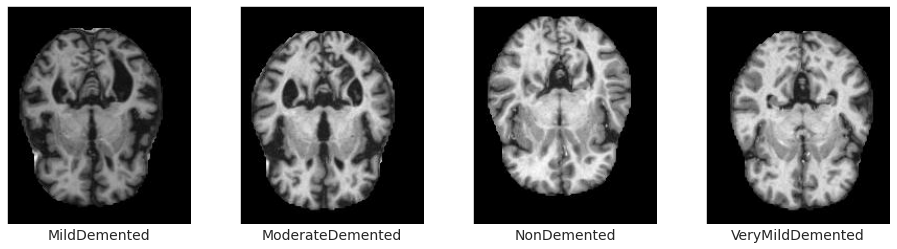

In [11]:
from torchvision.utils import make_grid
def show_classes(dataset, classes):
    images, labels = [], []
    for l in classes:
        for image, label in dataset:
            if label == l:
                images.append(image)
                labels.append(label)
                break;
    return images, labels
    
imgs = show_classes(train_ds, [0, 1, 2, 3])

plt.figure(1, figsize=(16, 4))
for i, img in enumerate(imgs[0]):
    j = i+1
    ax = plt.subplot(1, 4, j)  
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.xlabel(idx_to_class[i])
plt.show()

In [12]:
val_size = 628
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds , [train_size, val_size])

batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## GPU

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

cpu


## Defining the Model

In [15]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        # Applying layers & activation functions
        out = self.linear(out)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [16]:
class ResNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out) + x
        out = out.view(out.size(0), -1)
        return self.linear(out)

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(15360, output_size))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
class VGG16Network(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        out_features = self.vgg16.classifier[6].out_features        
        self.linear = nn.Linear(out_features, output_size)   
        
    def forward(self, xb):
        out = self.vgg16(xb)
        out = self.linear(out)
        return out

class VGG16Net(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.vgg16 = models.vgg16(pretrained=True)
    in_features = self.vgg16.classifier[0].in_features
    self.vgg16.classifier = nn.Linear(in_features, output_size)

  def forward(self, x):
    return self.vgg16(x)

class DenseNet(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.densenet = models.densenet161(pretrained=True)
        out_features = self.densenet.classifier.out_features
        self.linear = nn.Linear(out_features, output_size)   
        
    def forward(self, xb):
        out = self.densenet(xb)
        out = self.linear(out)
        return out
        
class DenseNet2(nn.Module):
  def __init__(self, output_size):
      super().__init__()
      self.densenet = models.densenet161(pretrained=True)
      in_features = self.densenet.classifier.in_features
      self.densenet.classifier = nn.Linear(in_features, output_size)

  def forward(self, xb):
      out = self.densenet(xb)
      return out

## Training the Model

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_dl):
    total_loss, total_acc = 0, 0
    model.eval()
    for x, y in val_dl:
        with torch.no_grad():
            output = model(x)
            loss = F.cross_entropy(output, y)
            acc = accuracy(output, y)
            total_loss += loss.item()
            total_acc += acc.item()
    return {'loss': total_loss/len(val_dl), 'acc': total_acc/len(val_dl)}

def epoch_end(epoch, metrics):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, metrics['train_loss'], metrics['loss'], metrics['acc']))


def train(model, train_dl, val_dl, epochs, lr, opt_funct = torch.optim.Adam):
    history = []
    optimizer = opt_funct(model.parameters(), lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x,y in train_dl:
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
        metrics = evaluate(model, val_dl)
        metrics['train_loss'] = train_loss/ len(train_dl)
        epoch_end(epoch, metrics)
        history.append(metrics)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_one_cycle(model, train_dl, test_dl, epochs, max_lr, weight_decay = 0, grad_clip = None, opt_funct = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_funct(model.parameters(), max_lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        lrs = []
        for x,y in train_dl:
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            lrs.append(get_lr(optimizer))
            sched.step()
        metrics = evaluate(model, val_dl)
        metrics['train_loss'] = train_loss/ len(train_dl)
        metrics['lrs'] = lrs
        epoch_end(epoch, metrics)
        history.append(metrics)
    return history

## Analyzing the learning Curve

In [20]:
def plot_accuracies(history):
    accuracies = [x['acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

### Evaluating the model after training.

In [21]:
#train_ds[0][0].shape
input_size = 3 * 208 * 176 
output_size = 4

## Feed Forward Network

In [22]:
model = to_device(FeedforwardNetwork(input_size, output_size), device)
model

FeedforwardNetwork(
  (linear): Linear(in_features=109824, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=4, bias=True)
)

In [23]:
history = [evaluate(model, val_dl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
epochs = 10
history += train(model, train_dl, val_dl, epochs, lr = 0.0001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.2812, val_loss: 0.9717, val_acc: 0.5346
Epoch [1], train_loss: 1.0424, val_loss: 0.9440, val_acc: 0.5339
Epoch [2], train_loss: 1.0885, val_loss: 1.1186, val_acc: 0.4626
Epoch [3], train_loss: 0.9984, val_loss: 1.0887, val_acc: 0.4489
Epoch [4], train_loss: 1.0062, val_loss: 0.9974, val_acc: 0.5534
Epoch [5], train_loss: 0.9639, val_loss: 0.9893, val_acc: 0.5073
Epoch [6], train_loss: 0.9615, val_loss: 0.9526, val_acc: 0.5405
Epoch [7], train_loss: 0.9692, val_loss: 0.9158, val_acc: 0.5315
Epoch [8], train_loss: 0.9420, val_loss: 1.0673, val_acc: 0.4315
Epoch [9], train_loss: 0.9432, val_loss: 0.9222, val_acc: 0.5666


In [25]:
evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'acc': 0.5109375, 'loss': 1.1909775540232659}

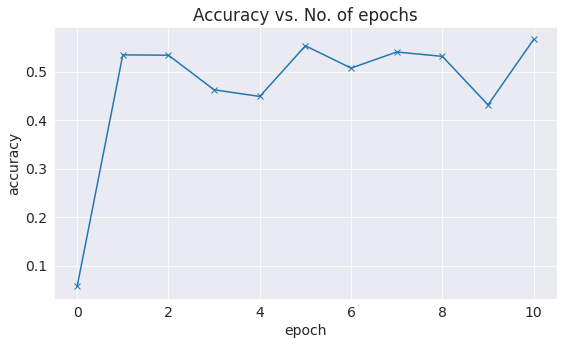

In [26]:
plot_accuracies(history)

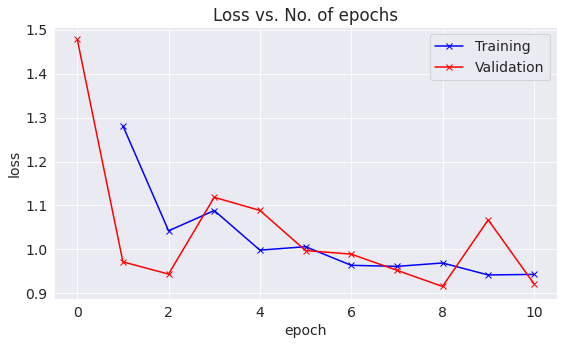

In [27]:
plot_losses(history)

## ResNet

In [28]:
res_model = to_device(ResNetwork(input_size, output_size), device)
res_model

ResNetwork(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (linear): Linear(in_features=109824, out_features=4, bias=True)
)

In [29]:
res_history = [evaluate(res_model, val_dl)]
res_history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'acc': 0.4067307680845261, 'loss': 1.2968478441238402}]

In [30]:
epochs = 10
res_history += train(res_model, train_dl, val_dl, epochs, lr = 0.001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 4.4660, val_loss: 1.7734, val_acc: 0.5264
Epoch [1], train_loss: 3.5154, val_loss: 2.6303, val_acc: 0.4088
Epoch [2], train_loss: 2.6588, val_loss: 3.3164, val_acc: 0.5179
Epoch [3], train_loss: 3.1680, val_loss: 1.5868, val_acc: 0.5172
Epoch [4], train_loss: 2.5573, val_loss: 2.1756, val_acc: 0.4775
Epoch [5], train_loss: 2.6171, val_loss: 1.7916, val_acc: 0.5424
Epoch [6], train_loss: 2.6637, val_loss: 2.1065, val_acc: 0.5214
Epoch [7], train_loss: 1.9238, val_loss: 2.0530, val_acc: 0.5264
Epoch [8], train_loss: 2.6808, val_loss: 1.9284, val_acc: 0.5314
Epoch [9], train_loss: 2.3402, val_loss: 1.9993, val_acc: 0.4918


In [31]:
evaluate(res_model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'acc': 0.4745907738804817, 'loss': 2.586762015894055}

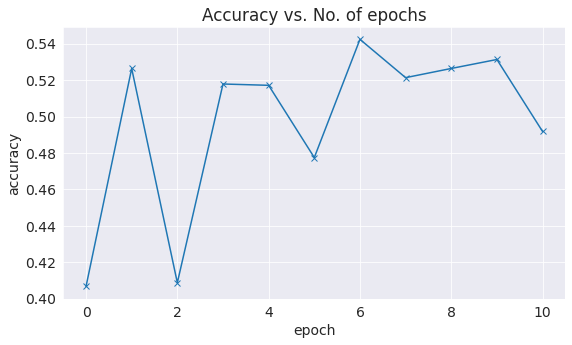

In [32]:
plot_accuracies(res_history)

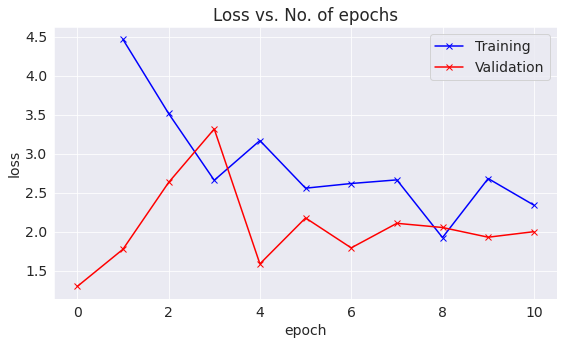

In [33]:
plot_losses(res_history)

## DenseNet

In [34]:
densenet = to_device(DenseNet(output_size), device)
densenet

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=

In [35]:
densenet_history = [evaluate(densenet, val_dl)]
densenet_history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'acc': 0.3436298072338104, 'loss': 1.8858369588851929}]

In [ ]:
epochs = 5
densenet_history += train(densenet, train_dl, val_dl, epochs, 0.0001)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
evaluate(densenet, test_dl)

In [ ]:
plot_accuracies(densenet_history)

In [ ]:
plot_losses(densenet_history)